In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import requests
import os, glob
from bs4 import BeautifulSoup
import urllib
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import NoAlertPresentException
from selenium.webdriver import ActionChains
from selenium.webdriver.support.ui import Select
import unittest, time, re
from sklearn.linear_model import LinearRegression
import array as arr
import scipy.stats as st
import math
import matplotlib.gridspec as gridspec
import random
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import datetime

### 產出檔案的副函式
* 功能：將檔案輸出成csv檔
* Result 是檔案路徑，請依據自身電腦設定

In [49]:
def OutputCSV(SAMPLE_List,filename):   
    Result ='data path'+filename+'.csv'
    df_SAMPLE = pd.DataFrame.from_dict(SAMPLE_List)
    df_SAMPLE.to_csv( Result  , index=False ) 
    print( '成功產出'+Result )

## 自動化下載資料

#### (1) 自動登入網頁
* 在執行前請先確認在此notebook同目錄中有沒有下載chrome driver

In [33]:
#使用者名稱 密碼
driver = webdriver.Chrome()
url='API url'
driver.get(url)
elem_user = driver.find_element_by_name("username")
elem_user.send_keys("username")
elem_pwd = driver.find_element_by_name("password")
elem_pwd.send_keys("password")
elem_pwd.send_keys(Keys.RETURN)

#開始抓取csv 的javascript元素

#### (2) 抓取資料
* 藉由 chrome driver 操縱登入網頁，並下載資料
* ! 注意 執行時請勿移動滑鼠會造成執行中斷

In [35]:
# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
action = ActionChains(driver)
dropdown=''
csvgetxpath=''
csvselectbox=''
csvcolclick=''
csvcolchoose=''
#操控網頁
csv_doc=driver.find_element_by_xpath(dropdown)
driver.find_element(By.XPATH, dropdown).click()
time.sleep(1)
csv_more=driver.find_element(By.XPATH, '')
action.move_to_element(csv_more).perform()
time.sleep(1)
driver.find_element(By.XPATH, csvgetxpath).click()
time.sleep(2)
#點選以爐次為欄位名稱
#下拉選單xpath會刷新
driver.find_element(By.CLASS_NAME,csvcolclick).click()
time.sleep(1)
box=driver.find_element(By.CLASS_NAME,csvcolclick)
sel_chose=box.find_element(By.CLASS_NAME,csvcolchoose)
sel_chose
Select(sel_chose).select_by_value('boolean:false')
time.sleep(1)
driver.find_element(By.CLASS_NAME,'btn-success').click()


### (3).資料讀取防傻
* entries 為資料下載名稱請確認
* filesloc 參數為資料路徑，請依自身電腦設定設定

In [159]:
def loaddata(filesloc):
    entries = os.listdir('')
    entries

    date_file_list = []
    for Path, Folder, FileName in os.walk(filesloc):
        x = 1
        for File in FileName:
                    stats = os.stat(Path + "//" + File)
                    lastmod_date = time.localtime(stats[8])
                    date_file_tuple = lastmod_date, File
                    date_file_list.append(date_file_tuple)
        date_file_list.sort()

    # [i[0時間 1檔名] for i in date_file_list][第幾個]
    for k in range(len([i[0] for i in date_file_list])):
#         print(time.mktime([i[0] for i in date_file_list][k]))
        if time.mktime([i[0] for i in date_file_list][k])==time.mktime(max([i[0] for i in date_file_list])):
#             print('in loop')
            final_filename=[i[1] for i in date_file_list][k]
#             print(time.mktime([i[0] for i in date_file_list][k]))
        else:
            pass
    return final_filename


## 時區變換，日期切分
* 將gravana網站上的資料進行分析，多出[DATETME] [date] [timearea]三個欄位進行紀錄 
* 將台灣時區 [+08:00] 替換成越南的 [+07:00]

In [77]:
def timeprocess(raw):
    #變更時區
    
    #時間標記切分
#     split_temp=raw['Time'].Series.str.split('+',expand=True)
#     new=pd.DataFrame({'DATETIME':[0],'date':[0],'time':[0],'timearea':[0]},index=[1])
#     new
#     raw=raw.append(new)
    raw.loc[:,'DATETIME'] = 0
    raw.loc[:,'date'] = 0
    raw.loc[:,'time'] = 0 
    raw.loc[:,'timearea'] = 0
    for i in raw.index:
        raw.loc[i,'DATETIME']=raw.loc[i,'Time'].split('+', 1)[0]
        raw.loc[i,'date']=raw.loc[i,'Time'].split('+', 1)[0].split('T', 1)[0]
        raw.loc[i,'time']=raw.loc[i,'Time'].split('+', 1)[0].split('T', 1)[1]
        raw.loc[i,'timearea']='+07:00'
    for k in raw['DATETIME'].index:
        raw.loc[k,'DATETIME']=raw.loc[k,'DATETIME'].replace("T", " ")
#         k=k.replace("T", " ")
        
    
#     raw = pd.DataFrame(raw.Time.str.split('+',1).tolist(),
#                                  columns = ['datetime','timearea'])
    
    
    return raw

In [78]:
filesloc='data path'
final_filename=loaddata(filesloc)
filesloc_new=filesloc+'/'+final_filename
raw1 = pd.read_csv(filesloc_new,sep =";")

## 報表
* rawtemp 參數為經過timeprocess()函式的gravana下載檔案
* raw_temp_diff() 為將rawtemp 中的溫度進行一次差分

In [52]:
#1. 開關機時間
# (1)生成一次差分資料
def raw_temp_diff(raw_temp):
    raw_temp_diff=raw_temp[raw_temp.columns[1:9]].diff()
    for col in raw_temp.columns[10:14]:
        raw_temp_diff[col]=0
        for i in raw_temp_diff.index:
            raw_temp_diff.loc[i,col]=raw_temp.loc[i,col]
    raw_temp_diff=raw_temp_diff.replace(np.nan, 0)
    return raw_temp_diff

* octime為產生爐子開啟時間還有爐子關閉時間的
* 是利用判斷一次差分值進行位置判斷

In [81]:
# (2)用差分資料判斷開機與關機，再用index去抓時間
#先定義連續5分鐘溫度都在上升，再抓第一個index為開機時間
#從後面回來，若開始波動三分鐘，則未開始波動的那個index的時間即為關機時間
#開始時間
def octime(raw_temp_diff):
    print('=====================================open and close time=====================================')
    for col in raw_temp_diff.columns[0:8]:
        riselist=[]
    #     print(len(raw_temp_diff),len(raw_temp),'report generation start')
        for i in raw_temp_diff.index:
            if raw_temp_diff.loc[i,col]>0.5:
                riselist=np.append(riselist,raw_temp_diff.loc[i,col])
    #             print(riselist)
                if len(riselist)>3:
                    stime=raw_temp_diff.loc[i,'time']
                    si=i
                    break
            else:
                riselist=[]
                continue
        print('===================================================================================')
    #     print(col,'open time = ',stime,'start index = ',si,'close time = ',raw_temp_diff.loc[len(raw_temp_diff)-1,'time'])
        print(col,'open time = ',stime,'close time = ',raw_temp_diff.loc[len(raw_temp_diff)-1,'time'])
    #     print(' '*len(col),'close time = ',raw_temp_diff.loc[len(raw_temp_diff)-1,'time'])

## 依真實時間產出報告
* 利用資料中的時間欄位抓取一小時內的資料

In [54]:
#圖表用dataframe副函式
# 起爐時間 or 開機時間
def report_generator(col,raw_temp):
    si=25
    #每個爐次起始index迴圈
    timetag=[si]
    for i in raw_temp.index:
    #     print(datetime.datetime.strptime(raw_temp.loc[i,'time'],"%H:%M:%S"),datetime.datetime.strptime(timetag[-1],"%H:%M:%S"))
        if 3560<=(datetime.datetime.strptime(raw_temp.loc[i,'time'],"%H:%M:%S")-datetime.datetime.strptime(raw_temp.loc[timetag[-1],'time'],"%H:%M:%S")).seconds<=3660:
            timetag=np.append(timetag,i)
            continue
    report_df_act=pd.DataFrame({"Date":[],"time":[],"Max":[],"Min":[],"Mean":[]})
    #若迴圈中(關爐時間) - (一小時起始時間) < 3600 則跳出迴圈
    for num,k in enumerate(timetag):
        if (datetime.datetime.strptime(raw_temp.loc[len(raw_temp)-1,'time'],"%H:%M:%S")-datetime.datetime.strptime(raw_temp.loc[k,'time'],"%H:%M:%S")).seconds<3500:
            
#             print(k,len(raw_temp)-1,num)
            report_df_act.loc[num,"Max"]=raw_temp.loc[k:len(raw_temp)-1,col].max()
            report_df_act.loc[num,"Min"]=raw_temp.loc[k:len(raw_temp)-1,col].min()
            report_df_act.loc[num,"Mean"]=raw_temp.loc[k:len(raw_temp)-1,col].mean()
            report_df_act.loc[num,"time"]=raw_temp.loc[k,'time']+' ~ '+raw_temp.loc[len(raw_temp)-1,'time']
#             print('==============================last hour has done=============================')
            break
#         print(k,timetag[num+1]-1,num)
        report_df_act.loc[num,"time"]=raw_temp.loc[k,'time']+' ~ '+raw_temp.loc[timetag[num+1]-1,'time']
        report_df_act.loc[num,"Max"]=raw_temp.loc[k:timetag[num+1]-1,col].max()
        report_df_act.loc[num,"Min"]=raw_temp.loc[k:timetag[num+1]-1,col].min()
        report_df_act.loc[num,"Mean"]=raw_temp.loc[k:timetag[num+1]-1,col].mean()
#         print('==================================',num+1,'th hour has done','==================================')
    report_df_act.loc[:,'Date']=raw_temp['date']
    return report_df_act
    
#     try:
        
#     except IndexError:
#         pass

## 報表圖表生成

In [17]:
df_perhour=report_generator('Temp1(Pre-baking Zone)',raw_temp)

NameError: name 'report_generator' is not defined

### timeseriesplot 為將連續爐八個區域的溫度隨時間變化的連續曲線給畫出來

In [156]:
def timeseriesplot(raw_temp):
    fig=plt.figure(figsize=(20,20))
    scalelst=[np.arange(135, 145, 1),np.arange(130, 145, 1),np.arange(90, 145, 5)]
    scalelst1=[np.arange(100, 105, 1),np.arange(95, 105, 1),np.arange(80,105,5)]

    for q,cate in enumerate(report_generator(raw_temp.columns[1],raw_temp).columns[2:3]): 
        colorlist=['r','b','g','black','darkgoldenrod','darkslategray','purple','chocolate']
        #max,min,mean 包起來
        ax=fig.add_subplot(3,1,q+1)
        ax1=ax.twinx()
        for h,col in enumerate(raw_temp.columns[2:9]):
            y=report_generator(col,raw_temp)[cate]
            x=report_generator(col,raw_temp)["time"]

            ax.plot(x,y,'-o',color=colorlist[h],label=col)
        #     ax.bar(x,y,width=0.05,color=colorlist[h],label=col)
        ax.set_title(raw_temp.loc[0,'date']+'  [ '+cate+' ]  ',fontsize=20)
        ax.set_ylabel('degree Celcious',fontsize=20)
        ax.set_xlabel('time (hours)',fontsize=20)
        ax.grid(color='black', linestyle='-', linewidth=0.5)
        ax.set_yticks(scalelst[q])
        ax1.plot(x, report_generator('Temp1(Pre-baking Zone)',raw_temp)[cate],'-o',color='brown',label='Temp1(Pre-baking Zone)')
        ax1.set_yticks(scalelst1[q])
        ax.legend(loc=8)
        ax1.legend(loc=0)
        ax1.set_ylabel('degree Celcious for Temp1(Pre-baking Zone)',fontsize=10)

### 各時段爐次的 MEAN 比較
* histoplot(raw_temp)效果如圖，是為了分別將每一時段 八個區域的爐子溫度畫在一起進行比較

In [157]:
def histoplot(raw_temp):
    fig=plt.figure(figsize=(20,40))
    for q,cate in enumerate(report_generator(raw_temp.columns[1],raw_temp).columns[2:3]): 
        for i in report_generator('Temp1(Pre-baking Zone)',raw_temp).index:
            histolist=[]
            x=[]
            ax2=fig.add_subplot(3*len(report_generator('Temp1(Pre-baking Zone)',raw_temp))/2,2,q*len(report_generator('Temp1(Pre-baking Zone)',raw_temp))+i+1)
            for h,col in enumerate(raw_temp.columns[2:9]):
        #         print(col,'===',report_generator(col,raw_temp)['time'][i],'===',report_generator(col,raw_temp)['Max'][i])
                histolist=np.append(histolist,report_generator(col,raw_temp)[cate][i])
                x=np.append(x,col[:5])
            y=histolist
            ax2.bar(x,y,width=0.5,label=col,alpha=0.7,color=[ 'red', 'green', 'blue', 'cyan','orange','purple','darkslategray'])
        #     ax2.set_xticks(np.arange(len(x)),x)
            ax2.set_title(report_generator('Temp1(Pre-baking Zone)',raw_temp).loc[i,'time']+'  [ '+cate+' ]  ',fontsize=20)
            ax2.set_ylabel('degree Celcious',fontsize=20)
            ax2.set_xlabel('heating zone number',fontsize=20)
            ax2.set_ylim([120,145])
    fig.tight_layout()    


### 各個爐次每一小時 MEAN
* 執行效果如圖，是分別將各區域，每時段的溫度疊在一起畫，進行比較

In [154]:
def bar(raw_temp):
    fig=plt.figure(figsize=(20,13))
    for j,mmm in enumerate(['Mean']):
        ax2=fig.add_subplot(3,1,j+1)
        x=raw_temp.columns[1:9]
        widthlist=[0.35,0.2,-0.2,-0.35]
        alignlist=['edge','center']
        for i in report_generator('Temp1(Pre-baking Zone)',raw_temp).index:
            for h,col in enumerate(raw_temp.columns[1:9]):
                histolist=[]
        #         print(col,'===',report_generator(col,raw_temp)['time'][i],'===',report_generator(col,raw_temp)['Max'][i])
                histolist=np.append(histolist,report_generator(col,raw_temp)['Max'][i])
                y=histolist
                low = min(y)
                high = max(y)
        #         ax2.set_ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
                ax2.set_ylim([140, 148])
                ax2.bar(x,y,width=random.choice(widthlist),label=col,alpha=0.6,align=random.choice(alignlist))
        ax2.legend(report_generator('Temp1(Pre-baking Zone)',raw_temp).loc[:,'time'], bbox_to_anchor=(0.35, 1.25),ncol=3)
        ax2.set_title('Compare zone heaters by time ['+mmm+']',fontsize=20)
        ax2.set_ylabel('degree Celcious',fontsize=20)
        ax2.set_xlabel('heating zone number',fontsize=20)
    fig.tight_layout() 

### 效能占歷史紀錄百分比與排名

In [84]:
#1 讀取歷史檔案
# 這是在長期趨勢觀察的檔案"8_14_steady_data"中丟出的溫度記錄dataframe
%store -r cdf
cdf

,Temp1 std,Temp1 temperature rising speed,Temp2 std,Temp2 temperature rising speed,Temp3 std,Temp3 temperature rising speed,Temp4 std,Temp4 temperature rising speed,Temp5 std,Temp5 temperature rising speed,Temp6 std,Temp6 temperature rising speed,Temp7 std,Temp7 temperature rising speed,Temp8 std,Temp8 temperature rising speed
2019-10-19,1.013387,4.273333,2.336264,5.510526,2.244400,6.462500,2.007617,5.463158,1.650012,2.959375,1.254602,4.136364,1.116397,4.118182,1.037721,2.260000
2019-10-23,NaN,2.420000,NaN,3.465517,NaN,4.008000,2.007617,5.247368,NaN,2.496970,NaN,3.085185,NaN,2.406061,0.954604,2.384848
2019-10-24,1.178073,7.587500,3.091078,14.357143,3.285176,14.914286,2.521463,10.833333,1.090871,5.675000,1.157392,6.950000,0.920277,8.227273,0.682188,3.642105
2019-10-25,0.992278,4.285714,2.189837,6.778571,2.275292,6.293333,1.916223,5.641176,1.619339,2.570968,NaN,2.959259,NaN,2.962963,0.919495,2.660000
2019-10-26,1.485598,10.760000,3.091078,12.585714,3.496713,17.660000,3.102902,17.960000,1.380942,13.816667,1.651363,16.540000,0.995705,9.200000,0.671751,10.362500
2019-10-28,1.178073,7.237500,2.887411,11.237500,3.095504,12.175000,2.678986,11.687500,1.313541,4.036364,1.216758,4.330000,1.063002,4.230000,0.761280,3.537500
2019-10-29,0.988394,4.253846,2.240335,6.884615,2.275292,6.013333,1.964203,5.940000,NaN,2.347059,1.182843,4.227778,NaN,2.393548,0.973618,2.097143
2019-10-30,1.102018,4.377778,2.887411,7.937500,3.095504,7.237500,2.678986,6.775000,1.157872,3.625000,1.157392,5.340000,1.001580,3.011765,0.740900,2.382609
2019-10-31,NaN,3.818750,2.194147,5.572222,NaN,5.527778,1.916492,5.500000,1.619339,2.700000,NaN,3.033333,1.116397,3.586364,0.973618,2.200000
2019-11-02,NaN,3.261111,2.155348,6.440000,2.275292,6.466667,1.928114,6.131250,1.375948,3.544000,1.235969,4.209524,NaN,3.852174,0.740900,3.882609


### 溫升段抓取
* temprisegrabber()
* raw_temp 是增加了時間欄位的gravana下載資料
* speed_std_df中每區域有一個欄位，欄位[Temp_n speed]是當天溫升段的溫升速率，，一共有16個欄位

In [58]:
#2 抓取今天溫升段
#raw_temp
def temprisegrabber(raw_temp):
    speed_std_df=pd.DataFrame({})
    for m in range(1,9,1):
        glist=raw_temp.loc[:,raw_temp.columns[m]]
        glist_diff=glist.diff()
        loclist=[]
        for k,gd in enumerate(glist_diff):
            if gd>0.5:
                loclist=np.append(loclist,k)
                if glist[k]>140:
                    break
                elif glist[k]>100 and m==1:
                    break
                else:
                    pass
            else:
                continue

        tr=raw_temp.loc[loclist[0]:loclist[-1],raw_temp.columns[m]]
        trdiff=(raw_temp.loc[loclist[0]:loclist[-1],raw_temp.columns[m]].diff())
        trdiff[:1]=trdiff.mean()
        speed=(tr.max()-tr.min())/len(tr)
        std=np.std(trdiff, ddof=1)
    #     speed_std_df.loc[0,raw_temp.columns[m][:5]+' std          ']=std
        speed_std_df.loc[0,raw_temp.columns[m][:5]+' speed (C/min)']=speed
    return speed_std_df

### 評估當日爐子效能
* cdf為從"8_14_steady_data.ipynb"傳來的檔案
* 先將cdf中的溫升段速度進行泡沫排序之後，在比較出當日的溫升速度在歷史資料中排第幾個

In [151]:
#3 計算名次
def ranking(speed_std_df,cdf):
    for j,ss in enumerate(speed_std_df.columns):
    #     print(ss)
        p=speed_std_df.loc[0,ss]
        l=cdf.loc[:,cdf.columns[j]]
        l= [m for m in l if str(m) != 'nan']
        ls=sorted(l)

        for d,n in enumerate(ls):
       
            if (p<n or p==n):
                print(ss[:11]+' = '+' '+str(round(p, 2))+' '+ss[-7:]+' higher than '+str(float(d*100/(len(ls)-1)))+'% of history datas')
                print('======================================================================================')
                break
            else:
    #             print(n)
                continue

speed_std_df.columns[range(1,len(speed_std_df.columns)-1,2)]

### 報表一鍵生成DEMO區 
* img為報表簽署欄位的圖片

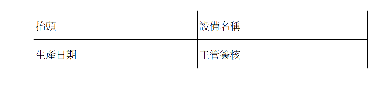

report exported time = 2020-08-27 13:12:15.
=====================================open and close time=====================================
('Temp1(Pre-baking Zone)', 'open time = ', '08:03:00', 'close time = ', '17:41:00')
('Temp2(Gelling Zone I)', 'open time = ', '08:19:00', 'close time = ', '17:41:00')
('Temp3(Gelling Zone II)', 'open time = ', '08:19:00', 'close time = ', '17:41:00')
('Temp4(Gelling Zone III)', 'open time = ', '08:19:00', 'close time = ', '17:41:00')
('Temp5(Curing Zone I)', 'open time = ', '08:19:00', 'close time = ', '17:41:00')
('Temp6(Curing Zone II)', 'open time = ', '08:17:00', 'close time = ', '17:41:00')
('Temp7(Curing Zone III)', 'open time = ', '08:17:00', 'close time = ', '17:41:00')
('Temp8(Curing Zone IV)', 'open time = ', '08:17:00', 'close time = ', '17:41:00')
('====================report==================', 'Temp1(Pre-baking Zone)', '===================done======================')
         Date    Max        Mean    Min                 time
0  2020-0

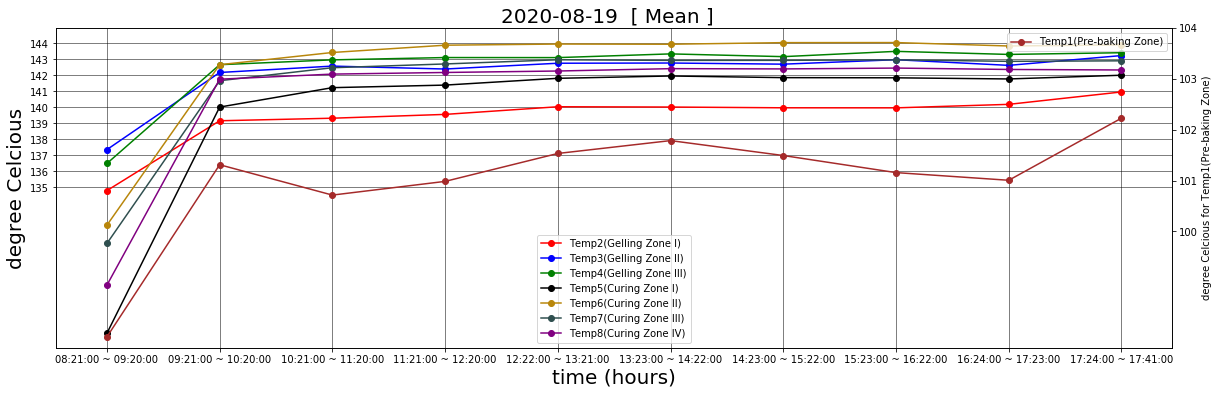

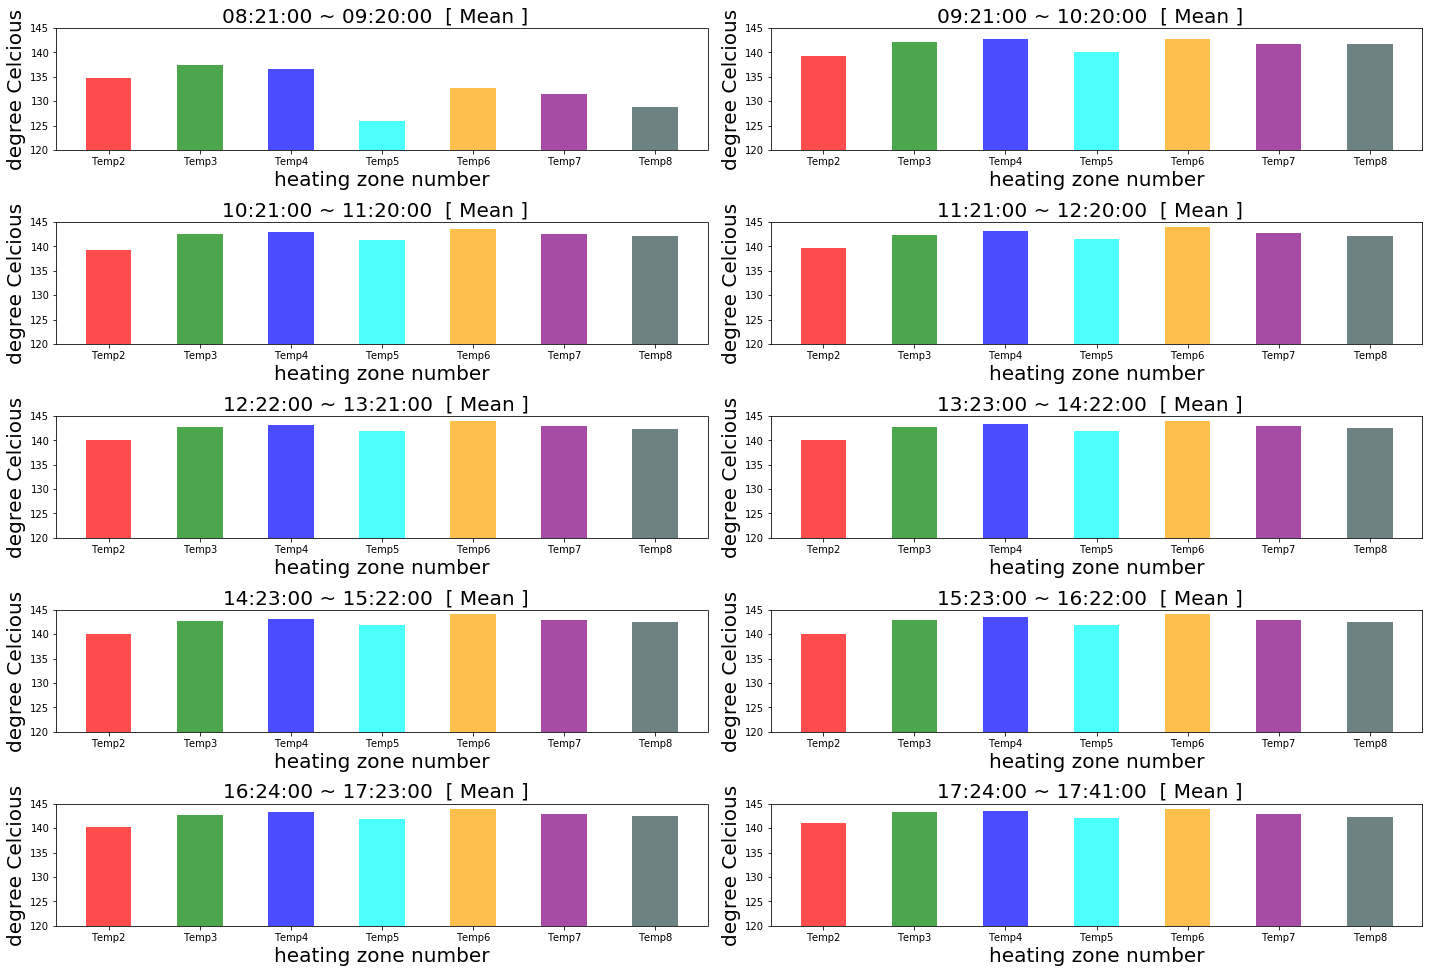

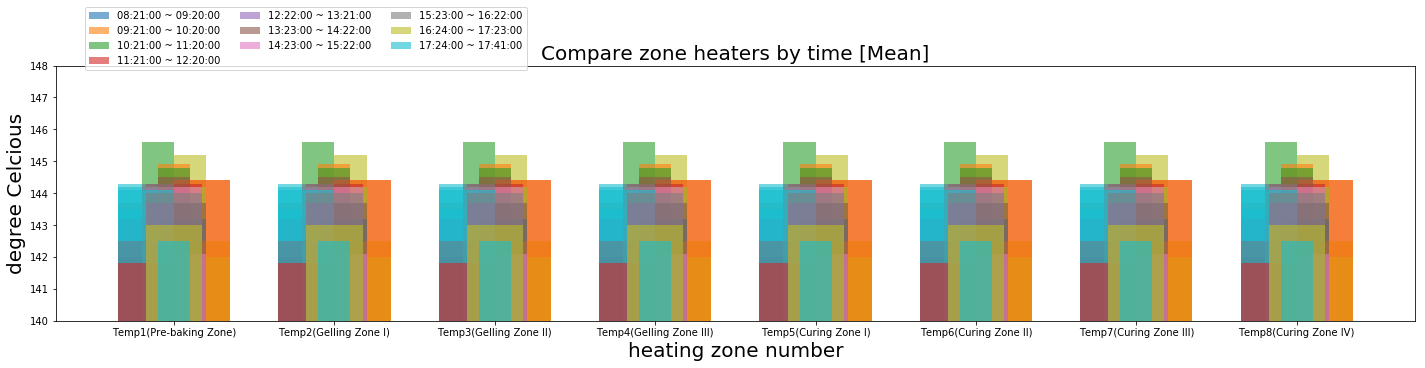

In [158]:
#操縱網頁
#讀取資料

import matplotlib.image as mpimg
# load
img = mpimg.imread('image path') 
# 此時 img 就已經是一個 np.array 了，可以對它進行任意處理
# height, width, channel=(360, 480, 3)
h,w,c = img.shape 
# show
plt.imshow(img) # 顯示圖片
plt.axis('off') # 不顯示座標軸
plt.show()
current_datetime = datetime.datetime.now()
print("report exported time = "+str(current_datetime)[:20])
#表格生成
filesloc='data path'
final_filename=loaddata(filesloc)
filesloc_new=filesloc+'/'+final_filename
raw1 = pd.read_csv(filesloc_new,sep =";")
raw_temp=timeprocess(raw1)
octime(raw_temp_diff(raw_temp))
for col in raw_temp.columns[1:9]:
    print('====================report==================',col,'===================done======================')
    print(report_generator(col,raw_temp))
#時序
timeseriesplot(raw_temp)
#各時段
histoplot(raw_temp)
#各爐子每時段
bar(raw_temp)
#標準差溫升速度
print(temprisegrabber(raw_temp))
ranking(temprisegrabber(raw_temp),cdf)
#列印時間
